# **Imports**

In [1]:
from utils_models import *
from utils_dataloaders import *

from sklearn.utils.class_weight import compute_class_weight

from matplotlib.patches import Patch

# import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, random_split
# import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

import geopandas as gpd
import numpy as np

# **Data Example**

label
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 7])  |  0.0  |  1.0
rgb
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 3, 256, 256])  |  3.1325292587280273  |  204.62545776367188
dem
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  597.962646484375  |  610.0032348632812
osm
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  0.0  |  1.0
ep
<class 'torch.Tensor'>  |  torch.float32  |  torch.Size([1, 1, 256, 256])  |  3.858466625213623  |  91.63953399658203


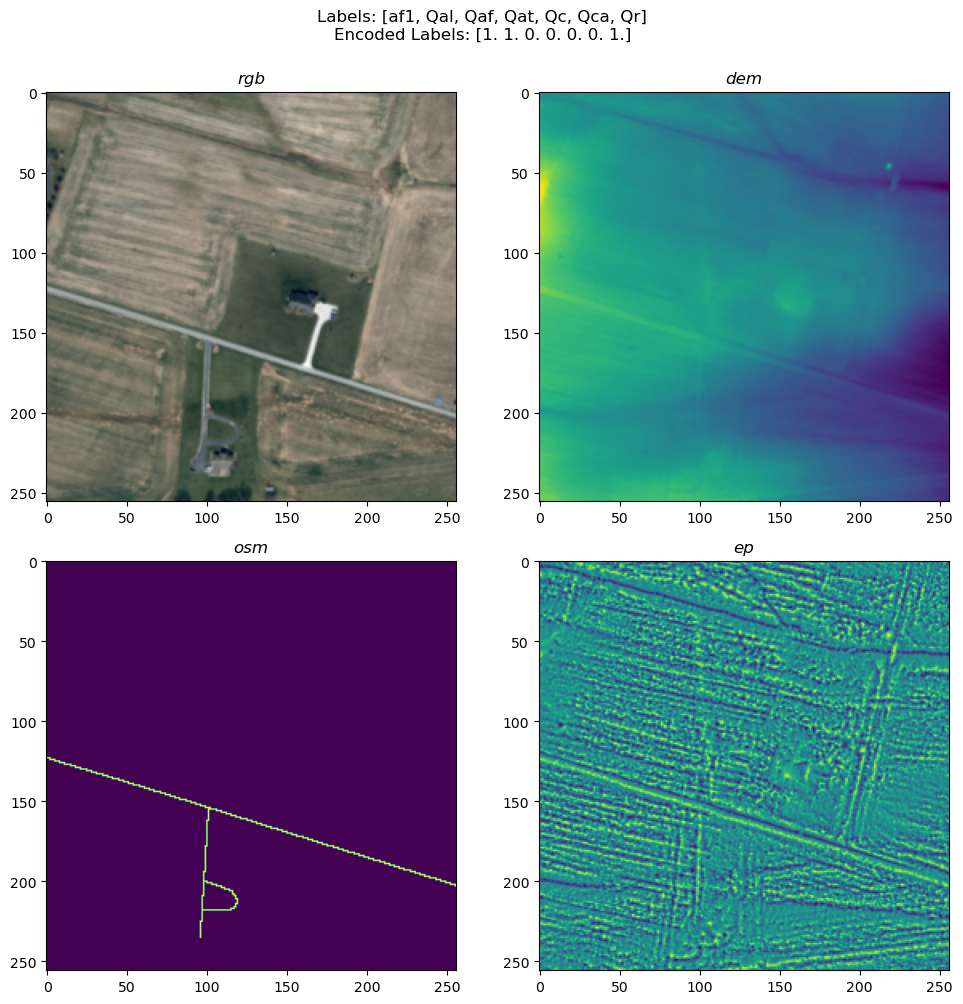

In [2]:
#######################################
# Verify Dataset and DataLoader Output
#######################################

# get list of patch IDs
patch_ids_path = r'../data//patches_warren/patch_ids.csv'    # path to patch id csv
patch_ids = pd.read_csv(patch_ids_path, header=None)         # read csv as df
ids = patch_ids.iloc[:,0]

# directory where patches are located
data_dir = r'../data/patches_warren'

# modality names and unique identifier filename substrings to use.
modalities = {'rgb': ['aerialr.tif', 
                      'aerialg.tif', 
                      'aerialb.tif'], 
              'dem': ['dem.tif'], 
              'osm': ['osm.tif'], 
              'ep': ['ep_5x5.tif']}

# custom multimodal dataset with paired images
example_dataset = MultiModalDataset(ids=ids, 
                                    data_dir=data_dir, 
                                    modalities=modalities, 
                                    norm_params=None, 
                                    augment=True, 
                                    task='classification')


##### example dataloader with batch size of 1 for visualization
example_loader = DataLoader(example_dataset, batch_size=1)
example = next(iter(example_loader))


##### print data report
for modality in example.keys():
    print(modality)
    print(f"{type(example[modality])}  |  {example[modality].dtype}  |  {example[modality].shape}  |  {example[modality].min()}  |  {example[modality].max()}")


##### plot modalities & labels
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.ravel()

idx = 0
for modality in example.keys():
    if not 'label' in modality:
        image = prep_image_for_plot(example[modality][0])
        ax[idx].imshow(image)
        ax[idx].set_title(modality, style='italic')
        idx += 1
    else:
        label_vec = example['label'].numpy().ravel()

plt.suptitle(f"Labels: [af1, Qal, Qaf, Qat, Qc, Qca, Qr]\nEncoded Labels: {label_vec}", y=1)
plt.tight_layout()
plt.show()

# **Data Selection**

## Model Directory Setup

In [2]:
model_root = r'../models'
if not os.path.isdir(model_root):
    os.makedirs(model_root)

classification_dir = r'../models/classification'
if not os.path.isdir(classification_dir):
    os.makedirs(classification_dir)

for _, dirs, _ in os.walk(classification_dir):
    model_number = str(len(dirs) + 1).zfill(2)
    model_dir = os.path.join(classification_dir, f"model_{model_number}")
    os.makedirs(model_dir)
    break


## Patch Selection

In [3]:
#########################################################
# Select Spatially Independent & Non-Overlapping Patches
#########################################################

# path to validation and training patches GeoJSON
patches_path = r'../data/warren/patches_256_50.geojson'

# directory path for model metadata
model_dir = r'../models/classification/model_01'

# size of validation set
val_size = 1024

# size of test set
test_size = 1024


##### read patches GeoJSON into geodataframe
gdf = gpd.read_file(patches_path)


##### select test set
gdf_test, gdf_remaining = randomly_select_indpendent_patch_sets(gdf, val_size, seed=111)


##### select validation & training sets
gdf_val, gdf_train = randomly_select_indpendent_patch_sets(gdf_remaining, val_size, seed=111)


##### save validation and training patches
gdf_train.to_file(f"{model_dir}/patches_train.geojson", driver='GeoJSON')
gdf_val.to_file(f"{model_dir}/patches_val.geojson", driver='GeoJSON')
gdf_test.to_file(f"{model_dir}/patches_test.geojson", driver='GeoJSON')

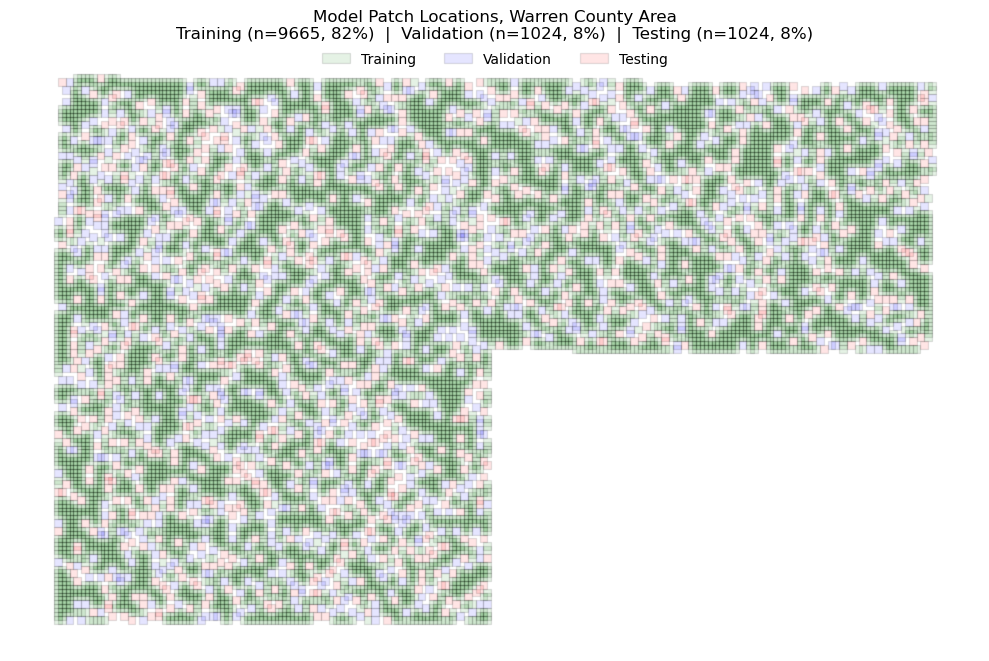

In [4]:
#############################
# Visualize Selected Patches
#############################

##### plot patches
fig, ax = plt.subplots(figsize=(10,8))

# plot
gdf_train.plot(ax=ax, facecolor='green', edgecolor='k', linewidth=1, alpha=0.1, label='Training')
gdf_val.plot(ax=ax, facecolor='blue', edgecolor='k', linewidth=1, alpha=0.1, label='Validation')
gdf_test.plot(ax=ax, facecolor='red', edgecolor='k', linewidth=1, alpha=0.1, label='Testing')

# legend
train_patch = Patch(facecolor='green', edgecolor='k', linewidth=1, alpha=0.1, label='Training')
val_patch = Patch(facecolor='blue', edgecolor='k', linewidth=1, alpha=0.1, label='Validation')
test_patch = Patch(facecolor='red', edgecolor='k', linewidth=1, alpha=0.1, label='Testing')
ax.legend(handles=[train_patch, val_patch, test_patch], loc='center', bbox_to_anchor=(0.5, 0.98), frameon=False, ncols=3)

# title
n = len(gdf_train) + len(gdf_val) + len(gdf_test)
train_percent = len(gdf_train) / n * 100
val_percent = len(gdf_val) / n * 100
test_percent = len(gdf_test) / n * 100
train_subtitle = f"Training (n={len(gdf_train)}, {int(train_percent)}%)"
val_subtitle = f"Validation (n={len(gdf_val)}, {int(val_percent)}%)"
test_subtitle = f"Testing (n={len(gdf_test)}, {int(test_percent)}%)"
ax.set_title(f"Model Patch Locations, Warren County Area\n{train_subtitle}  |  {val_subtitle}  |  {test_subtitle}")

ax.set_axis_off()
plt.tight_layout()
plt.show()

## DataLoaders

In [4]:
#########################################################################
# Setup Custom Datasets and DataLoaders for Train, Validation, Test Sets
#########################################################################

# get lists of training, validation, and test patch IDs
# training...
train_path = r'../models/classification/model_01/patches_train.geojson'
gdf_train = gpd.read_file(train_path)
train_ids = gdf_train['patch_id'].to_list()

# validation...
val_path = r'../models/classification/model_01/patches_val.geojson'
gdf_val = gpd.read_file(val_path)
val_ids = gdf_val['patch_id'].to_list()

# testing...
test_path = r'../models/classification/model_01/patches_test.geojson'
gdf_test = gpd.read_file(test_path)
test_ids = gdf_test['patch_id'].to_list()

# directory where patches are stored
patch_dir = r'../data/patches_warren'

# modality names and unique identifier filename substrings to use in modeling
modalities = {'rgb': ['aerialr.tif', 
                      'aerialg.tif', 
                      'aerialb.tif']}

# normalization parameters
norm_stats_path = r'../data/warren/image_stats.csv'
df = pd.read_csv(norm_stats_path)
norm_params = {}
for modality, channels in modalities.items():
    means = []
    stds = []
    for channel in channels:
        stats = df.loc[df['path']==channel]
        means.append(stats['mean'].item())
        stds.append(stats['std'].item())
    norm_params = {modality: [means, stds]}


##### create custom datasets
train_dataset = MultiModalDataset(ids=train_ids, 
                                  data_dir=patch_dir, 
                                  modalities=modalities, 
                                  norm_params=norm_params, 
                                  augment=True, 
                                  task='classification')

val_dataset = MultiModalDataset(ids=val_ids, 
                                data_dir=patch_dir, 
                                modalities=modalities, 
                                norm_params=norm_params, 
                                augment=False, 
                                task='classification')

test_dataset = MultiModalDataset(ids=test_ids, 
                                 data_dir=patch_dir, 
                                 modalities=modalities, 
                                 norm_params=norm_params, 
                                 augment=False, 
                                 task='classification')


#### create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

## Class Distributions

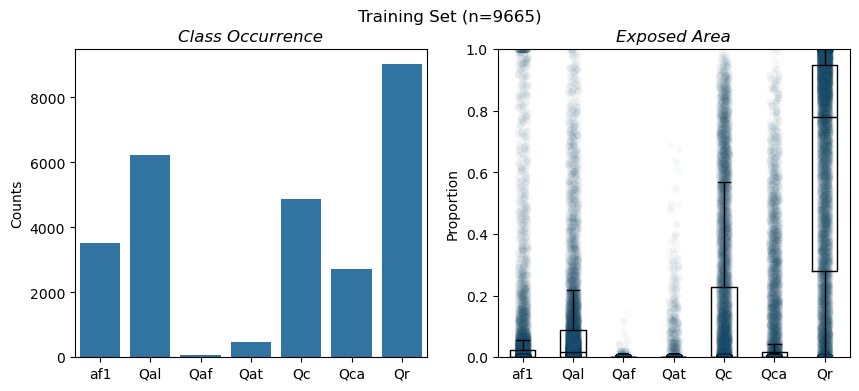

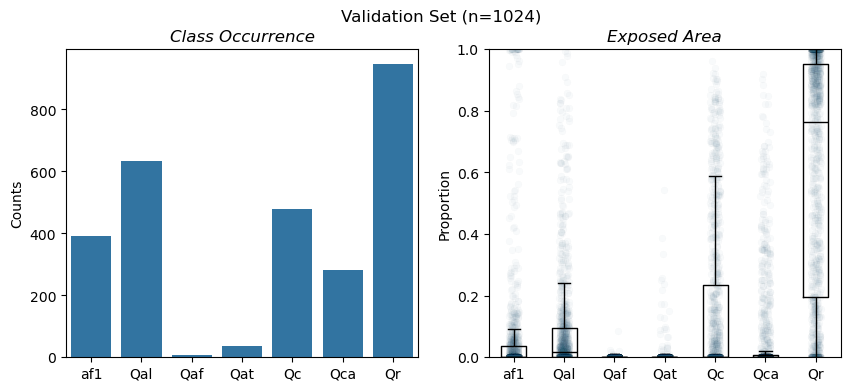

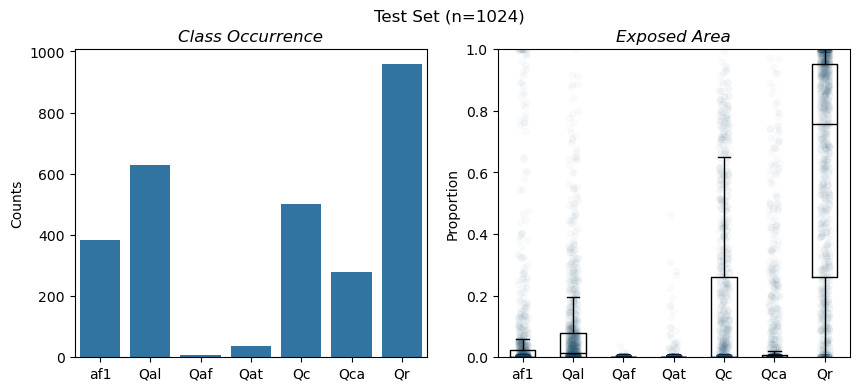

In [5]:
count_path = r'../data/warren/patches_256_50_labels.csv'
area_path = r'../data/warren/patches_256_50_areas.csv'
titles = ['Training Set', 'Validation Set', 'Test Set']
patch_ids = [train_ids, val_ids, test_ids]

for set_name, patches in zip(titles, patch_ids):
    patches = [patch for patch in patches]
    fig = plot_class_distributions(patches, count_path, area_path, set_name)
    plt.show(fig)

# **Model Training**

In [5]:
#####################
# Confirm GPU Status
#####################

if torch.cuda.is_available():
    print('GPU is available. Using GPU.')
else:
    print('GPU not available. Using CPU.')

GPU not available. Using CPU.


In [ ]:
########################
# Training & Validation
########################

# parameters...
output_dir = r'../data/models/classification/model_01'
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
out_classes = 7
modality_channels = {'rgb': 3}
model = FullModel(out_classes=out_classes, modality_channels=modality_channels).to(device)
optimizer = optim.Adam(model.parameters())
# criterion = nn.BCEWithLogitsLoss()

# focal loss...
target_path = glob.glob(r'../data/warren/*_labels.csv')[0]
targets = pd.read_csv(target_path)
targets = targets.iloc[:, 1:]
alpha = len(targets) / (7 * targets.sum(axis=0)).to_numpy()
alpha = torch.tensor(alpha, dtype=torch.float32).view(1, -1).to(device)
gamma = 2.0
reduction = 'mean'
criterion = FocalLoss(alpha=alpha, gamma=gamma, reduction=reduction)


##### train
epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc = train_model(model, 
                                                                               train_loader, 
                                                                               val_loader, 
                                                                               criterion, 
                                                                               optimizer, 
                                                                               device, 
                                                                               num_epochs, 
                                                                               output_dir)

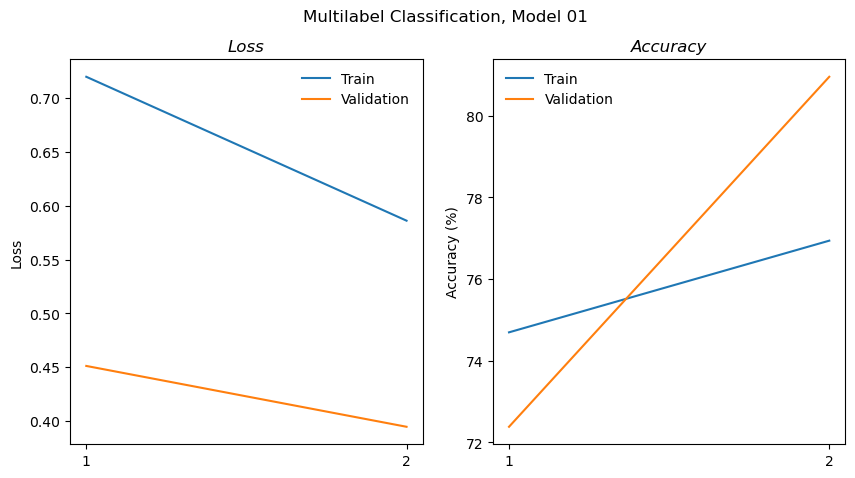

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

epochs = range(1, len(epoch_train_loss)+1)

ax[0].plot(epochs, epoch_train_loss, label='Train')
ax[0].plot(epochs, epoch_val_loss, label='Validation')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss', style='italic')

ax[1].plot(epochs, epoch_train_acc, label='Train')
ax[1].plot(epochs, epoch_val_acc, label='Validation')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy', style='italic')

for axes in ax:
    axes.legend(frameon=False)
    axes.set_xticks(epochs)

plt.suptitle('Multilabel Classification, Model 01')
plt.show()


# Test

## *Per label Metrics*

In [ ]:
##### Precision, Recall, F1, AUC-ROC, Average Precision

In [ ]:
##### Visualizations - Precision-Recall Curve & ROC Curve

## *Overall Metrics*

In [ ]:
##### Averaged over all labels - Precision, Recall, F1, AUC-ROC, & mean Average Precision (mAP), Hamming loss, Subset Accuracy

## *Tuned Results*

In [6]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model.load_state_dict(torch.load(r'../data/warren/model_output/best_model.pth', map_location='cpu'))

# model.eval()

In [7]:
# val_patches = pd.read_csv(r'../data/warren/model_output/validation_patches.csv')
# val_patches = val_patches['patch_id'].to_list()

# test_patches = pd.read_csv(r'../data/warren/model_output/test_patches.csv')
# test_patches = test_patches['patch_id'].to_list()

# print(len(val_patches))
# print(len(test_patches))

In [8]:
# # define transforms...
# # normalization values calculated from entire dataset
# rgb_means = [82.34144592285156, 82.34144592285156, 60.32989501953125]
# rgb_stds = [35.15250749710626, 35.15250749710626, 11.364835230788147]
# dem_means = [693.0260620117188]
# dem_stds = [58.23499697372154]

# rgb_transforms = transforms.Compose([transforms.Normalize(rgb_means, rgb_stds)])
# dem_transforms = transforms.Compose([transforms.Normalize([dem_means], [dem_stds])])


# # datasets...
# val_dataset = MultiModalDataset(val_patches,
#                                 r'../data/warren/patches_09_27_2024',
#                                 transform_rgb=rgb_transforms,
#                                 transform_dem=dem_transforms,
#                                 horiz_flip=False, 
#                                 vert_flip=False, 
#                                 rand_rot=False)

# test_dataset = MultiModalDataset(test_patches,
#                                  r'../data/warren/patches_09_27_2024',
#                                  transform_rgb=rgb_transforms,
#                                  transform_dem=dem_transforms,
#                                  horiz_flip=False, 
#                                  vert_flip=False, 
#                                  rand_rot=False)

# # dataloaders...
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)

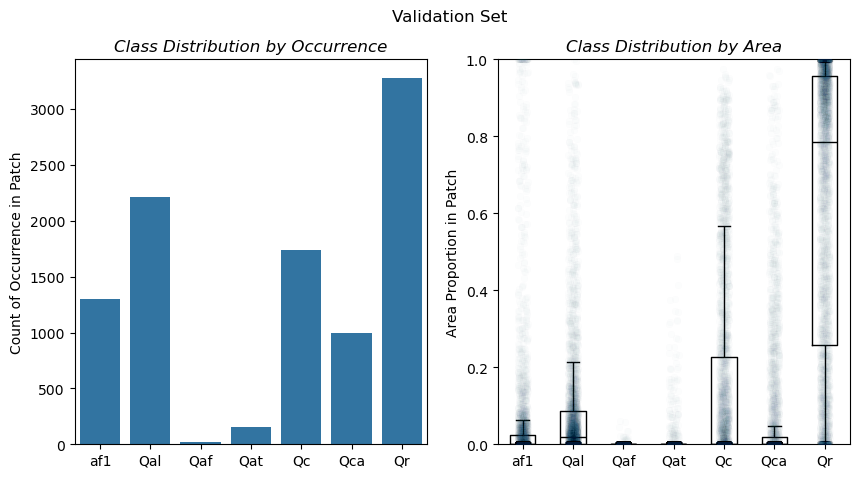

In [33]:
count_path = r'../data/warren/patches_256_50_labels.csv'
df_count = pd.read_csv(count_path)
df_count = df_count.loc[df_count['patch_id'].isin(val_patches)]
counts = df_count.iloc[:, 1:].sum(axis=0)
counts = pd.DataFrame(counts)
counts.head()

area_path = r'../data/warren/patches_256_50_areas.csv'
df_area = pd.read_csv(area_path)
df_area = df_area.loc[df_area['patch_id'].isin(val_patches)]
df_area_long = df_area.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')


fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# counts...
sns.barplot(ax=ax[0], data=counts, x=counts.index, y=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count of Occurrence in Patch')
ax[0].set_title('Class Distribution by Occurrence', style='italic')


# areas...
sns.boxplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', showfliers=False, fill=False, color='k', width=0.5, linewidth=1)

sns.stripplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', jitter=True, edgecolor='k', linewidth=0.2, alpha=0.01, facecolor='#3A6D8C')

ax[1].set_xlabel('')
ax[1].set_ylabel('Area Proportion in Patch')
ax[1].set_title('Class Distribution by Area', style='italic')


plt.ylim(0,1)
plt.suptitle('Validation Set')
plt.show()

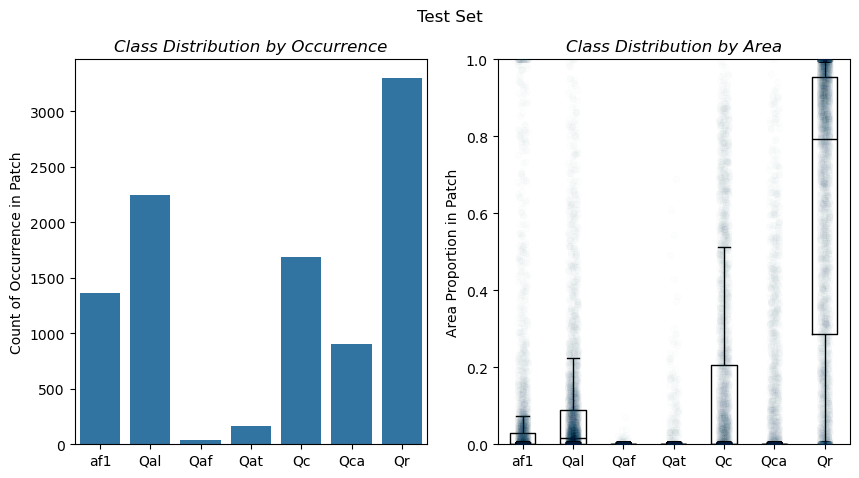

In [34]:
count_path = r'../data/warren/patches_256_50_labels.csv'
df_count = pd.read_csv(count_path)
df_count = df_count.loc[df_count['patch_id'].isin(test_patches)]
counts = df_count.iloc[:, 1:].sum(axis=0)
counts = pd.DataFrame(counts)
counts.head()

area_path = r'../data/warren/patches_256_50_areas.csv'
df_area = pd.read_csv(area_path)
df_area = df_area.loc[df_area['patch_id'].isin(test_patches)]
df_area_long = df_area.iloc[:, 1:].melt(var_name='Geologic Map Unit', value_name='Proportion')


fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# counts...
sns.barplot(ax=ax[0], data=counts, x=counts.index, y=0)
ax[0].set_xlabel('')
ax[0].set_ylabel('Count of Occurrence in Patch')
ax[0].set_title('Class Distribution by Occurrence', style='italic')


# areas...
sns.boxplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', showfliers=False, fill=False, color='k', width=0.5, linewidth=1)

sns.stripplot(ax=ax[1], data=df_area_long, x='Geologic Map Unit', y='Proportion', jitter=True, edgecolor='k', linewidth=0.2, alpha=0.01, facecolor='#3A6D8C')

ax[1].set_xlabel('')
ax[1].set_ylabel('Area Proportion in Patch')
ax[1].set_title('Class Distribution by Area', style='italic')


plt.ylim(0,1)
plt.suptitle('Test Set')
plt.show()

In [35]:
test_predictions, test_targets = test_model(model, test_loader, device='cpu', output_dir=None)

In [38]:
test_predictions.shape

(3520, 7)

In [44]:
df = pd.DataFrame(columns=['MapUnit', 'Precision', 'Recall', 'F1', 'AUC-ROC'])

for idx, unit in enumerate(['af1', 'Qal', 'Qaf', 'Qat', 'Qc', 'Qca', 'Qr']):
    df.loc[idx, 'MapUnit'] = unit
    preds = test_predictions[idx]
    targs = test_targets[idx]
    precision, recall, f1, auc_roc = calculate_label_precision_recall_f1_aucroc(preds, targs, threshold=0.5)
    df.loc[idx, 'Precision'] = precision
    df.loc[idx, 'Recall'] = recall
    df.loc[idx, 'F1'] = f1
    df.loc[idx, 'AUC-ROC'] = auc_roc

df.head(10)

,MapUnit,Precision,Recall,F1,AUC-ROC
0,af1,1.0,0.5,0.666667,0.75
1,Qal,1.0,1.0,1.0,1.0
2,Qaf,1.0,1.0,1.0,1.0
3,Qat,1.0,0.8,0.888889,0.9
4,Qc,0.75,0.6,0.666667,0.55
5,Qca,1.0,0.5,0.666667,0.75
6,Qr,1.0,1.0,1.0,1.0


In [46]:
from sklearn.metrics import average_precision_score, hamming_loss, accuracy_score

def calculate_global_metrics(targets, predictions, threshold=0.5):

  predictions_binary = (predictions >= threshold).astype(int)
  
  macro_precision = precision_score(targets, predictions_binary, average='macro')
  macro_recall = recall_score(targets, predictions_binary, average='macro')
  macro_f1 = f1_score(targets, predictions_binary, average='macro')

  mean_ap = average_precision_score(targets, predictions, average='macro')
  h_loss = hamming_loss(targets, predictions_binary)
  subset_acc = accuracy_score(targets, predictions_binary)

  return macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc

In [47]:
macro_precision, macro_recall, macro_f1, mean_ap, h_loss, subset_acc = calculate_global_metrics(test_targets, test_predictions, threshold=0.5)

print(macro_precision)
print(macro_recall)
print(macro_f1)
print(mean_ap)
print(h_loss)
print(subset_acc)


0.71016710129731
0.5902367160860654
0.6389963011524892
0.7588916511734148
0.10673701298701299
0.4434659090909091


/opt/miniconda3/envs/cs612/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
